In [1]:
%matplotlib inline
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [3]:
def get_BER(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    aux = np.unpackbits(rcv)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    
    pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
    rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
    tx_extended = np.tile(tx, int(rcv.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(rcv), np.unpackbits(tx_extended))))

In [4]:
def noDiffEnc_Corrector(file, inv = False):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    
    if inv:
        rcv = np.invert(rcv)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    
    pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
    rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
    
    new_arr = []
    tx_inverted = np.invert(tx)
    rcv_splitted = np.split(rcv, len(rcv)/len(tx))
    for x in rcv_splitted:
        comp1 = np.mean(np.equal(np.unpackbits(tx), np.unpackbits(x)))
        comp2 = np.mean(np.equal(np.unpackbits(tx_inverted), np.unpackbits(x)))
        if comp2 > comp1:
            new_arr.append(np.invert(x))
        else:
            new_arr.append(x)
    final_array = np.array(new_arr, dtype = np.uint8).ravel()
    
    tx_extended = np.tile(tx, int(rcv.shape[0]/len(tx)))
    return (1 - np.mean(np.equal(np.unpackbits(final_array), np.unpackbits(tx_extended))))

In [5]:
%%time
get_SNR("output.txt"), noDiffEnc_Corrector("output.data", inv = True)

CPU times: user 7.16 s, sys: 25 ms, total: 7.19 s
Wall time: 7.33 s


((21.234275609756097, 0.09303984009090088), 0.0)

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER


In [6]:
a = """

((1.1666320823170733, 0.6277396672209425), 0.08014491071428576)

((2.4590401463414633, 0.5518401309731306), 0.041552678571428525)

((3.173503780487805, 0.5177808037889134), 0.02966580357142856)

((4.159633292682927, 0.4127118633666211), 0.013982857142857186)

((4.886723658536585, 0.33264332645185685), 0.006936071428571444)

((5.445146951219512, 0.7372823545087549), 0.0045678571428571235)

((5.84337987804878, 0.3201790841171277), 0.0030919642857142327)

((6.97359268292683, 0.3250336988609657), 0.00095624999999999

((7.410721707317074, 0.5949175267145917), 0.001135357142857174)

((7.738218902439025, 0.36821937028580315), 0.00035401785714284095)

((7.777842439024389, 0.30993866221875827), 0.00035642857142859086)

((7.832157804878049, 0.28793140480543317), 0.0003199107142857205)

((8.699727439024388, 0.30071317352867216), 9.39285714285365e-05)

((9.154731585365854, 0.2470305103180059), 3.5357142857184165e-05)

((9.899430853658536, 0.29068694719368376), 9.732142857155068e-06)
"""

In [7]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [8]:
def print_lst_with_slash(lst):
    print("[ \\")
    for x in lst:
        print(f"{x}, \\")
    print("]")

In [9]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [10]:
simu = np.load("simu_bpsk.npy")

In [11]:
theory = np.load("theory_bpsk.npy")

In [12]:
print(plt.style.available)

['seaborn-dark-palette', 'classic', 'seaborn-darkgrid', 'dark_background', 'seaborn', 'fast', 'seaborn-muted', 'seaborn-notebook', 'tableau-colorblind10', 'seaborn-colorblind', 'seaborn-white', 'seaborn-poster', 'grayscale', 'ggplot', 'seaborn-bright', 'Solarize_Light2', 'seaborn-whitegrid', 'seaborn-talk', '_classic_test', 'fivethirtyeight', 'seaborn-dark', 'seaborn-pastel', 'seaborn-paper', 'bmh', 'seaborn-ticks', 'seaborn-deep']


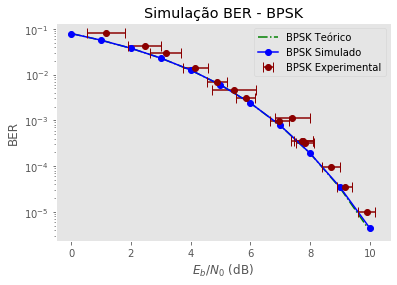

In [20]:
plt.style.use('ggplot')
plt.semilogy(EbN0_range, theory, "g-.", label = "BPSK Teórico")
plt.semilogy(EbN0_range, simu, "b-o", label = "BPSK Simulado")
plt.errorbar(snr_avgs, bers, xerr = np.array(snr_stds), fmt = "o", color = "darkred", capsize = 5, label = "BPSK Experimental")
plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK')
plt.xlabel(r'$E_b/N_0$ (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png", dpi = 300)